In [1]:
!pip install tensorflow==2.0.0-alpha0 
!pip install pretty_midi

import tensorflow as tf
from tensorflow.keras import backend as K
import glob
import random
import pretty_midi
import IPython
import numpy as np
from tqdm import tnrange, tqdm
from tqdm import notebook as tqdm
from random import shuffle, seed
import numpy as np
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Nadam
import numpy as np
from numpy.random import choice
import pickle
import matplotlib.pyplot as plt

import unicodedata
import re
import numpy as np
import os
import io
import time

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


/Users/annachesson/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/annachesson/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/annachesson/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/annachesson/anaconda3/lib/python3.7/site-packages/tensorf

In [2]:
#only have to run the first time you run the notebook on your computer
#!unzip maestro-v1.0.0-midi.zip

# Get All Midi Files

""#name of folder: 'maestro-v1.0.0/**/*.midi'


def get_list_midi(folder = 'maestro-v1.0.0/**/*.midi', seed_int = 666):
  """Get the list of all midi file in the folders
  
  Parameters
  ==========
  folder : str
    The midi folder.
  seed_int : int
    the random seed.
  
  Returns
  =======
  The midi files
  
  """
  list_all_midi = glob.glob(folder)
  seed(seed_int)
  shuffle(list_all_midi)
  return list_all_midi

list_all_midi = get_list_midi()""

len(list_all_midi)

In [3]:
class NoteTokenizer:
    
    def __init__(self):
      self.notes_to_index = {}
      self.index_to_notes = {}
      self.num_of_word = 0
      self.unique_word = 0
      self.notes_freq = {}
        
    def transform(self,list_array):
      """ Transform a list of note in string into index.
      
      Parameters
      ==========
      list_array : list
        list of note in string format
      
      Returns
      =======
      The transformed list in numpy array.
      
      """
      transformed_list = []
      for instance in list_array:
          transformed_list.append([self.notes_to_index[note] for note in instance])
      return np.array(transformed_list, dtype=np.int32)
 
    def partial_fit(self, notes):
        """ Partial fit on the dictionary of the tokenizer
        
        Parameters
        ==========
        notes : list of notes
        
        """
        for note in notes:
            note_str = ','.join(str(a) for a in note)
            if note_str in self.notes_freq:
                self.notes_freq[note_str] += 1
                self.num_of_word += 1
            else:
                self.notes_freq[note_str] = 1
                self.unique_word += 1
                self.num_of_word += 1
                self.notes_to_index[note_str], self.index_to_notes[self.unique_word] = self.unique_word, note_str
            
    def add_new_note(self, note):
        """ Add a new note into the dictionary

        Parameters
        ==========
        note : str
          a new note who is not in dictionary.  

        """
        assert note not in self.notes_to_index
        self.unique_word += 1
        self.notes_to_index[note], self.index_to_notes[self.unique_word] = self.unique_word, note
        
def generate_batch_song(list_all_midi, batch_music=16, start_index=0, fs=30, seq_len=50, use_tqdm=False):
    """
    Generate Batch music that will be used to be input and output of the neural network
    
    Parameters
    ==========
    list_all_midi : list
      List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    seq_len : int
      The sequence length of the music to be input of neural network
    use_tqdm : bool
      Whether to use tqdm or not in the function
    
    Returns
    =======
    Tuple of input and target neural network
    
    """
    
    assert len(list_all_midi) >= batch_music
    dict_time_notes = generate_dict_time_notes(list_all_midi, batch_music, start_index, fs, use_tqdm=use_tqdm)
    
    list_musics = process_notes_in_song(dict_time_notes, seq_len)
    collected_list_input, collected_list_target = [], []
     
    for music in list_musics:
        list_training, list_target = generate_input_and_target(music, seq_len)
        collected_list_input += list_training
        collected_list_target += list_target
    return collected_list_input, collected_list_target

def generate_dict_time_notes(list_all_midi, batch_song = 16, start_index=0, fs=30, use_tqdm=True):
    """ Generate map (dictionary) of music ( in index ) to piano_roll (in np.array)

    Parameters
    ==========
    list_all_midi : list
        List of midi files
    batch_music : int
      A number of music in one batch
    start_index : int
      The start index to be batched in list_all_midi
    fs : int
      Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    use_tqdm : bool
      Whether to use tqdm or not in the function

    Returns
    =======
    dictionary of music to piano_roll (in np.array)

    """
    assert len(list_all_midi) >= batch_song
    
    dict_time_notes = {}
    process_tqdm_midi = tqdm.tqdm(range(start_index, min(start_index + batch_song, len(list_all_midi)))) if use_tqdm else range(start_index,  min(start_index + batch_song, len(list_all_midi)))
    for i in process_tqdm_midi:
        midi_file_name = list_all_midi[i]
        if use_tqdm:
            process_tqdm_midi.set_description("Processing {}".format(midi_file_name))
        try: # Handle exception on malformat MIDI files
            midi_pretty_format = pretty_midi.PrettyMIDI(midi_file_name)
            piano_midi = midi_pretty_format.instruments[0] # Get the piano channels
            piano_roll = piano_midi.get_piano_roll(fs=fs)
            dict_time_notes[i] = piano_roll
        except Exception as e:
            print(e)
            print("broken file : {}".format(midi_file_name))
            pass
    return dict_time_notes

def generate_input_and_target(dict_keys_time, seq_len=50):
    """ Generate input and the target of our deep learning for one music.
    
    Parameters
    ==========
    dict_keys_time : dict
      Dictionary of timestep and notes
    seq_len : int
      The length of the sequence
      
    Returns
    =======
    Tuple of list of input and list of target of neural network.
    
       
    """
    # Get the start time and end time
    start_time, end_time = list(dict_keys_time.keys())[0], list(dict_keys_time.keys())[-1]
    list_training, list_target = [], []
    for index_enum, time in enumerate(range(start_time, end_time)):
        list_append_training, list_append_target = [], []
        start_iterate = 0
        flag_target_append = False # flag to append the test list
        if index_enum < seq_len:
            start_iterate = seq_len - index_enum - 1
            for i in range(start_iterate): # add 'e' to the seq list. 
                list_append_training.append('e')
                flag_target_append = True

        for i in range(start_iterate,seq_len):
            index_enum = time - (seq_len - i - 1)
            if index_enum in dict_keys_time:
                list_append_training.append(','.join(str(x) for x in dict_keys_time[index_enum]))      
            else:
                list_append_training.append('e')

        # add time + 1 to the list_append_target
        if time+1 in dict_keys_time:
            list_append_target.append(','.join(str(x) for x in dict_keys_time[time+1]))
        else:
            list_append_target.append('e')
        list_training.append(list_append_training)
        list_target.append(list_append_target)
    return list_training, list_target

def process_notes_in_song(dict_time_notes, seq_len = 50):
    """
    Iterate the dict of piano rolls into dictionary of timesteps and note played
    
    Parameters
    ==========
    dict_time_notes : dict
      dict contains index of music ( in index ) to piano_roll (in np.array)
    seq_len : int
      Length of the sequence
      
    Returns
    =======
    Dict of timesteps and note played
    """
    list_of_dict_keys_time = []
    
    for key in dict_time_notes:
        sample = dict_time_notes[key]
        times = np.unique(np.where(sample > 0)[1])
        index = np.where(sample > 0)
        dict_keys_time = {}

        for time in times:
            index_where = np.where(index[1] == time)
            notes = index[0][index_where]
            dict_keys_time[time] = notes
        list_of_dict_keys_time.append(dict_keys_time)
    return list_of_dict_keys_time



# Sample 100 midi files from the datasets
These midi files will be used to train the neural network

# Get 200 midis file from the datasets.. 

sampled_200_midi = list_all_midi[0:100]  

We create a map of note -> index here using NoteTokenizer that we've defined before.  
This object will be used to transform the list of notes to be ready for the input of Neural Network

In [4]:
batch = 1
start_index = 0
note_tokenizer = NoteTokenizer()

for i in tqdm.tqdm(range(len(sampled_200_midi))):
    dict_time_notes = generate_dict_time_notes(sampled_200_midi, batch_song=1, start_index=i, use_tqdm=False, fs=5)
    full_notes = process_notes_in_song(dict_time_notes)
    for note in full_notes:
        note_tokenizer.partial_fit(list(note.values()))
   

NameError: name 'sampled_200_midi' is not defined

In [8]:
note_tokenizer.add_new_note('e') # Add empty notes

In [9]:
unique_notes = note_tokenizer.unique_word
print(unique_notes)

36540


# Make Architecture
Now we will make the architecture.. 
We will try to make the architecture as follow:
1. Embedding
2. LSTM
3. Self Head Attention
4. LSTM
5. Self Head Attention
6. Dense

In [10]:
seq_len = 50
EPOCHS = 4
BATCH_SONG = 16
BATCH_NNET_SIZE = 96
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5


We will use the code from here for self-attention  
https://github.com/CyberZHG/keras-self-attention/blob/master/keras_self_attention/seq_self_attention.py

In [11]:
class SeqSelfAttention(tf.keras.layers.Layer):

    ATTENTION_TYPE_ADD = 'additive'
    ATTENTION_TYPE_MUL = 'multiplicative'

    def __init__(self,
                 units=32,
                 attention_width=None,
                 attention_type=ATTENTION_TYPE_ADD,
                 return_attention=False,
                 history_only=False,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 use_additive_bias=True,
                 use_attention_bias=True,
                 attention_activation=None,
                 attention_regularizer_weight=0.0,
                 **kwargs):
        """Layer initialization.
        For additive attention, see: https://arxiv.org/pdf/1806.01264.pdf
        :param units: The dimension of the vectors that used to calculate the attention weights.
        :param attention_width: The width of local attention.
        :param attention_type: 'additive' or 'multiplicative'.
        :param return_attention: Whether to return the attention weights for visualization.
        :param history_only: Only use historical pieces of data.
        :param kernel_initializer: The initializer for weight matrices.
        :param bias_initializer: The initializer for biases.
        :param kernel_regularizer: The regularization for weight matrices.
        :param bias_regularizer: The regularization for biases.
        :param kernel_constraint: The constraint for weight matrices.
        :param bias_constraint: The constraint for biases.
        :param use_additive_bias: Whether to use bias while calculating the relevance of inputs features
                                  in additive mode.
        :param use_attention_bias: Whether to use bias while calculating the weights of attention.
        :param attention_activation: The activation used for calculating the weights of attention.
        :param attention_regularizer_weight: The weights of attention regularizer.
        :param kwargs: Parameters for parent class.
        """
        self.supports_masking = True
        self.units = units
        self.attention_width = attention_width
        self.attention_type = attention_type
        self.return_attention = return_attention
        self.history_only = history_only
        if history_only and attention_width is None:
            self.attention_width = int(1e9)

        self.use_additive_bias = use_additive_bias
        self.use_attention_bias = use_attention_bias
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)
        self.bias_initializer = tf.keras.initializers.get(bias_initializer)
        self.kernel_regularizer = tf.keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = tf.keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = tf.keras.constraints.get(kernel_constraint)
        self.bias_constraint = tf.keras.constraints.get(bias_constraint)
        self.attention_activation = tf.keras.activations.get(attention_activation)
        self.attention_regularizer_weight = attention_regularizer_weight
        self._backend = tf.keras.backend.backend()

        if attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self.Wx, self.Wt, self.bh = None, None, None
            self.Wa, self.ba = None, None
        elif attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self.Wa, self.ba = None, None
        else:
            raise NotImplementedError('No implementation for attention type : ' + attention_type)

        super(SeqSelfAttention, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'units': self.units,
            'attention_width': self.attention_width,
            'attention_type': self.attention_type,
            'return_attention': self.return_attention,
            'history_only': self.history_only,
            'use_additive_bias': self.use_additive_bias,
            'use_attention_bias': self.use_attention_bias,
            'kernel_initializer': tf.keras.regularizers.serialize(self.kernel_initializer),
            'bias_initializer': tf.keras.regularizers.serialize(self.bias_initializer),
            'kernel_regularizer': tf.keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': tf.keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': tf.keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': tf.keras.constraints.serialize(self.bias_constraint),
            'attention_activation': tf.keras.activations.serialize(self.attention_activation),
            'attention_regularizer_weight': self.attention_regularizer_weight,
        }
        base_config = super(SeqSelfAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            self._build_additive_attention(input_shape)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            self._build_multiplicative_attention(input_shape)
        super(SeqSelfAttention, self).build(input_shape)

    def _build_additive_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wt = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wt'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        self.Wx = self.add_weight(shape=(feature_dim, self.units),
                                  name='{}_Add_Wx'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_additive_bias:
            self.bh = self.add_weight(shape=(self.units,),
                                      name='{}_Add_bh'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

        self.Wa = self.add_weight(shape=(self.units, 1),
                                  name='{}_Add_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Add_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def _build_multiplicative_attention(self, input_shape):
        feature_dim = input_shape[2]

        self.Wa = self.add_weight(shape=(feature_dim, feature_dim),
                                  name='{}_Mul_Wa'.format(self.name),
                                  initializer=self.kernel_initializer,
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
        if self.use_attention_bias:
            self.ba = self.add_weight(shape=(1,),
                                      name='{}_Mul_ba'.format(self.name),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint)

    def call(self, inputs, mask=None, **kwargs):
        if isinstance(inputs, list):
            inputs, positions = inputs
            positions = K.cast(positions, 'int32')
            mask = mask[1]
        else:
            positions = None

        input_len = K.shape(inputs)[1]

        if self.attention_type == SeqSelfAttention.ATTENTION_TYPE_ADD:
            e = self._call_additive_emission(inputs)
        elif self.attention_type == SeqSelfAttention.ATTENTION_TYPE_MUL:
            e = self._call_multiplicative_emission(inputs)

        if self.attention_activation is not None:
            e = self.attention_activation(e)
        e = K.exp(e - K.max(e, axis=-1, keepdims=True))
        if self.attention_width is not None:
            ones = tf.ones((input_len, input_len))
            if self.history_only:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width - 1),
                    0,
                )
            else:
                local = tf.linalg.band_part(
                    ones,
                    K.minimum(input_len, self.attention_width // 2),
                    K.minimum(input_len, (self.attention_width - 1) // 2),
                )
            e = e * K.expand_dims(local, 0)
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            mask = K.expand_dims(mask)
            e = K.permute_dimensions(K.permute_dimensions(e * mask, (0, 2, 1)) * mask, (0, 2, 1))

        # a_{t} = \text{softmax}(e_t)
        s = K.sum(e, axis=-1)
        s = K.tile(K.expand_dims(s, axis=-1), K.stack([1, 1, input_len]))
        a = e / (s + K.epsilon())

        # l_t = \sum_{t'} a_{t, t'} x_{t'}
        v = K.batch_dot(a, inputs)
        if self.attention_regularizer_weight > 0.0:
            self.add_loss(self._attention_regularizer(a))

        if positions is not None:
            pos_num = K.shape(positions)[1]
            batch_indices = K.tile(K.expand_dims(K.arange(K.shape(inputs)[0]), axis=-1), K.stack([1, pos_num]))
            pos_indices = K.stack([batch_indices, positions], axis=-1)
            v = tf.gather_nd(v, pos_indices)
            a = tf.gather_nd(a, pos_indices)

        if self.return_attention:
            return [v, a]
        return v

    def _call_additive_emission(self, inputs):
        input_shape = K.shape(inputs)
        batch_size, input_len = input_shape[0], input_shape[1]

        # h_{t, t'} = \tanh(x_t^T W_t + x_{t'}^T W_x + b_h)
        q, k = K.dot(inputs, self.Wt), K.dot(inputs, self.Wx)
        q = K.tile(K.expand_dims(q, 2), K.stack([1, 1, input_len, 1]))
        k = K.tile(K.expand_dims(k, 1), K.stack([1, input_len, 1, 1]))
        if self.use_additive_bias:
            h = K.tanh(q + k + self.bh)
        else:
            h = K.tanh(q + k)

        # e_{t, t'} = W_a h_{t, t'} + b_a
        if self.use_attention_bias:
            e = K.reshape(K.dot(h, self.Wa) + self.ba, (batch_size, input_len, input_len))
        else:
            e = K.reshape(K.dot(h, self.Wa), (batch_size, input_len, input_len))
        return e

    def _call_multiplicative_emission(self, inputs):
        # e_{t, t'} = x_t^T W_a x_{t'} + b_a
        e = K.batch_dot(K.dot(inputs, self.Wa), K.permute_dimensions(inputs, (0, 2, 1)))
        if self.use_attention_bias:
            e = e + self.ba
        return e

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape, pos_shape = input_shape
            output_shape = (input_shape[0], pos_shape[1], input_shape[2])
        else:
            output_shape = input_shape
        if self.return_attention:
            attention_shape = (input_shape[0], output_shape[1], input_shape[1])
            return [output_shape, attention_shape]
        return output_shape

    def compute_mask(self, inputs, mask=None):
        if isinstance(inputs, list):
            mask = mask[1]
        if self.return_attention:
            return [mask, None]
        return mask

    def _attention_regularizer(self, attention):
        batch_size = K.cast(K.shape(attention)[0], K.floatx())
        input_len = K.shape(attention)[-1]
        return self.attention_regularizer_weight * K.sum(K.square(K.batch_dot(
            attention,
            K.permute_dimensions(attention, (0, 2, 1))) - tf.eye(input_len))) / batch_size

    @staticmethod
    def get_custom_objects():
      return {'SeqSelfAttention': SeqSelfAttention}

In [12]:
def create_model(seq_len, unique_notes, dropout=0.3, output_emb=100, rnn_unit=128, dense_unit=64):
  inputs = tf.keras.layers.Input(shape=(seq_len,))
  embedding = tf.keras.layers.Embedding(input_dim=unique_notes+1, output_dim=output_emb, input_length=seq_len)(inputs)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit, return_sequences=True))(embedding)
  forward_pass , att_vector = SeqSelfAttention(
      return_attention=True,
      attention_activation='sigmoid', 
      attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
      attention_width=50, 
      kernel_regularizer=tf.keras.regularizers.l2(1e-4),
      bias_regularizer=tf.keras.regularizers.l1(1e-4),
      attention_regularizer_weight=1e-4,
  )(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit, return_sequences=True))(forward_pass)
  forward_pass , att_vector2 = SeqSelfAttention(
      return_attention=True,
      attention_activation='sigmoid', 
      attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
      attention_width=50, 
      kernel_regularizer=tf.keras.regularizers.l2(1e-4),
      bias_regularizer=tf.keras.regularizers.l1(1e-4),
      attention_regularizer_weight=1e-4,
  )(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(rnn_unit))(forward_pass)
  forward_pass = tf.keras.layers.Dropout(dropout)(forward_pass)
  forward_pass = tf.keras.layers.Dense(dense_unit)(forward_pass)
  forward_pass = tf.keras.layers.LeakyReLU()(forward_pass)
  outputs = tf.keras.layers.Dense(unique_notes+1, activation = "softmax")(forward_pass)

  model = tf.keras.Model(inputs=inputs, outputs=outputs, name='generate_scores_rnn')
  return model

model = create_model(seq_len, unique_notes)

In [13]:
model.summary()

Model: "generate_scores_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 100)           3654100   
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           176640    
_________________________________________________________________
seq_self_attention (SeqSelfA [(None, 50, 256), (None,  65537     
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           296448    
_________________________________________________________________
seq_self_attention_1 (SeqSel [(None, 50, 256), 

In [14]:
#ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


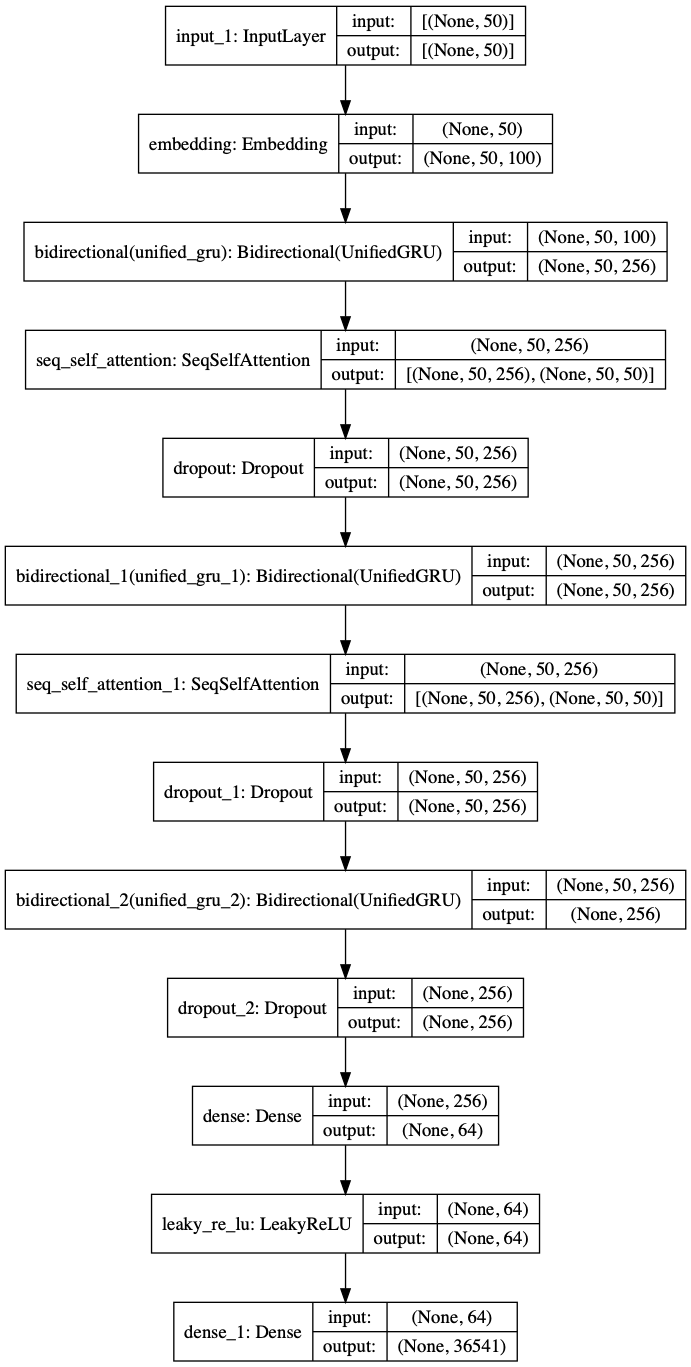

In [16]:
tf.keras.utils.plot_model(model, 'this_model.png', show_shapes=True)

# Train

In [17]:
import os
optimizer = Nadam()

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
loss_fn = sparse_categorical_crossentropy


In [12]:
class TrainModel:
  
  def __init__(self, epochs, note_tokenizer, sampled_200_midi, frame_per_second, 
               batch_nnet_size, batch_song, optimizer, checkpoint, loss_fn,
               checkpoint_prefix, total_songs, model):
    self.epochs = epochs
    self.note_tokenizer = note_tokenizer
    self.sampled_200_midi = sampled_200_midi
    self.frame_per_second = frame_per_second
    self.batch_nnet_size = batch_nnet_size
    self.batch_song = batch_song
    self.optimizer = optimizer
    self.checkpoint = checkpoint
    self.loss_fn = loss_fn
    self.checkpoint_prefix = checkpoint_prefix
    self.total_songs = total_songs
    self.model = model
    
  def train(self):
    for epoch in tqdm.tqdm(range(self.epochs),desc='epochs'):
      # for each epochs, we shufle the list of all the datasets
      shuffle(self.sampled_200_midi)
      loss_total = 0
      steps = 0
      steps_nnet = 0

      # We will iterate all songs by self.song_size
      for i in tqdm.tqdm(range(0,self.total_songs, self.batch_song), desc='MUSIC'):

        steps += 1
        inputs_nnet_large, outputs_nnet_large = generate_batch_song(
            self.sampled_200_midi, self.batch_song, start_index=i, fs=self.frame_per_second, 
            seq_len=seq_len, use_tqdm=False) # We use the function that have been defined here
        inputs_nnet_large = np.array(self.note_tokenizer.transform(inputs_nnet_large), dtype=np.int32)
        outputs_nnet_large = np.array(self.note_tokenizer.transform(outputs_nnet_large), dtype=np.int32)

        index_shuffled = np.arange(start=0, stop=len(inputs_nnet_large))
        np.random.shuffle(index_shuffled)

        for nnet_steps in tqdm.tqdm(range(0,len(index_shuffled),self.batch_nnet_size)):
          steps_nnet += 1
          current_index = index_shuffled[nnet_steps:nnet_steps+self.batch_nnet_size]
          inputs_nnet, outputs_nnet = inputs_nnet_large[current_index], outputs_nnet_large[current_index]
          
          # To make sure no exception thrown by tensorflow on autograph
          if len(inputs_nnet) // self.batch_nnet_size != 1:
            break
          loss = self.train_step(inputs_nnet, outputs_nnet)
          loss_total += tf.math.reduce_sum(loss)
          if steps_nnet % 20 == 0:
            print("epochs {} | Steps {} | total loss : {}".format(epoch + 1, steps_nnet, loss_total))

      checkpoint.save(file_prefix = self.checkpoint_prefix)
  
  @tf.function
  def train_step(self, inputs, targets):
    with tf.GradientTape() as tape:
      prediction = self.model(inputs)
      loss = self.loss_fn(targets, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    return loss

# Train Here
Beware that the time of one epoch is around 1 hour.

In [ ]:
seq_len = 50
EPOCHS = 4
BATCH_SONG = 16
BATCH_NNET_SIZE = 96
TOTAL_SONGS = len(sampled_200_midi)
FRAME_PER_SECOND = 5

train_class = TrainModel(EPOCHS, note_tokenizer, sampled_200_midi, FRAME_PER_SECOND,
                  BATCH_NNET_SIZE, BATCH_SONG, optimizer, checkpoint, loss_fn,
                  checkpoint_prefix, TOTAL_SONGS, model)

train_class.train()

# Save the model as h5 and The Tokenizer

In [ ]:
model.save('model_ep4.h5')
pickle.dump( note_tokenizer, open( "tokenizer.p", "wb" ) )

# Try To load the model and the Tokenizer

In [ ]:
model = tf.keras.models.load_model('model_ep4.h5', custom_objects=SeqSelfAttention.get_custom_objects())
note_tokenizer  = pickle.load( open( "tokenizer(1).p", "rb" ) )

# Generate Midi Files

In [ ]:
def generate_from_random(unique_notes, seq_len=50):
  generate = np.random.randint(0,unique_notes,seq_len).tolist()
  return generate
    
def generate_from_one_note(note_tokenizer, new_notes='35'):
  generate = [note_tokenizer.notes_to_index['e'] for i in range(49)]
  generate += [note_tokenizer.notes_to_index[new_notes]]
  return generate

In [13]:
def generate_notes(generate, model, unique_notes, max_generated=1000, seq_len=50):
  for i in tqdm(range(max_generated), desc='genrt'):
    test_input = np.array([generate])[:,i:i+seq_len]
    predicted_note = model.predict(test_input)
    random_note_pred = choice(unique_notes+1, 1, replace=False, p=predicted_note[0])
    generate.append(random_note_pred[0])
  return generate

In [ ]:
def write_midi_file_from_generated(generate, midi_file_name = "result.mid", start_index=49, fs=8, max_generated=1000):
  note_string = [note_tokenizer.index_to_notes[ind_note] for ind_note in generate]
  array_piano_roll = np.zeros((128,max_generated+1), dtype=np.int16)
  for index, note in enumerate(note_string[start_index:]):
    if note == 'e':
      pass
    else:
      splitted_note = note.split(',')
      for j in splitted_note:
        array_piano_roll[int(j),index] = 1
  generate_to_midi = piano_roll_to_pretty_midi(array_piano_roll, fs=fs)
  print("Tempo {}".format(generate_to_midi.estimate_tempo()))
  for note in generate_to_midi.instruments[0].notes:
    note.velocity = 100
  generate_to_midi.write(midi_file_name)

In [ ]:
max_generate = 200
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_random(unique_notes, seq_len)
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
write_midi_file_from_generated(generate, "random.mid", start_index=seq_len-1, fs=7, max_generated = max_generate)

In [ ]:
max_generate = 300
unique_notes = note_tokenizer.unique_word
seq_len=50
generate = generate_from_one_note(note_tokenizer, '72')
generate = generate_notes(generate, model, unique_notes, max_generate, seq_len)
write_midi_file_from_generated(generate, "one_note.mid", start_index=seq_len-1, fs=8, max_generated = max_generate)

In [ ]:
# function for plotting the attention weights, taken from MIT course
# https://github.com/aamini/introtodeeplearning_labs
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()


In [ ]:
start_sequence = 150
seq_len = 50

def visualize_attention(model, start_sequence, seq_len):
  """ This is where we utilize the eager execution of Tensorflow 2.
  
  """
  test_input = np.array([generate])[:,start_sequence:start_sequence+seq_len]
  out = test_input

  for i, layer in enumerate(model.layers):
    out = layer(out)
    if i == 3 or i == 6:
      print("Attention {}".format(i//3))
      attention = out[1][0].numpy()
      trans_input = test_input[0].astype(str).tolist()
      plot_attention(attention, trans_input, trans_input)
      out = out[0]

visualize_attention(model, start_sequence, seq_len)

In [ ]:
attention[30]